## Method
- Make prediction for city level using SEPP simplified (SEPPexp) using different DB.
- Compare models performance using hit rate and PAI.

## Hypothesis:
SEPPexp prediction performance is higher for models based on bigger datasets (DB with more data).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from services.prediction_experiment import PredictionExperiment

In [2]:
from services import prediction_metrics

Failed to import `rtree`.
Failed to import `rtree`.


In [3]:
from services.process_data import ProcessData
import pickle

In [4]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform

In [5]:
def get_hit_rate_from_dict(row,column,coverage):
    return row[column][coverage]

## Experimental design

In [6]:
train_dates = {'initial':'2018-09-01','final':'2018-09-30'}
validation_dates = {'initial':'2018-10-01','final':'2018-10-07'}
metrics = ''
aggregation = ''
filter_localidad = {'field':'','value':''}
model = "SEPPexp"

## SIEDCO

In [8]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/deduplicate_siedco_09062020.csv'
siedco_info = {'name':'SIEDCO','path':csv_path}

In [9]:
city_experiment = PredictionExperiment(dataset_info=siedco_info, custom_filter=filter_localidad,train_dates=train_dates, validation_dates=validation_dates, model=model,metrics='',aggregation_data='')
prediction_array = city_experiment.run_ncv_experiment(time_unit='',grid_size=150, outer_iterations='')

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (32,44) have mixed types. Specify dtype option on import or set low_memory=False.
  


train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 9, 30, 0, 0)}
current_validation_date 2018-10-01 00:00:00
RectangularRegion( (985137.4254012154,985520.8748214965) -> (1007214.0944495028,1022664.1295162059) )


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/open_cp/seppexp.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  omega = _np.sum(upper_trianglar_sums) / _np.sum(weighted_upper_trianglar_sums)


omega: 4.374482781901475, theta: 0.0055151009042604905
1940
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 1, 0, 0)}
current_validation_date 2018-10-02 00:00:00
RectangularRegion( (985137.4254012154,985520.8748214965) -> (1007214.0944495028,1022664.1295162059) )
omega: 3.211737309033009, theta: 0.005495484247211097
1981
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 2, 0, 0)}
current_validation_date 2018-10-03 00:00:00
RectangularRegion( (985137.4254012154,985520.8748214965) -> (1007214.0944495028,1022664.1295162059) )
omega: 0.7140766145538754, theta: 0.005853110054305284
2023
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 3, 0, 0)}
current_validation_date 2018-10-04 00:00:00
RectangularRegion( (985137.4254012154,985520.8748214965) -> (1007214.0944495028,1022664.1295162059) )
omega: 1.118656216843708, theta: 0.006

In [10]:
df_siedco = pd.DataFrame(prediction_array, columns =['initial-date','final-date','prediction','eval_pts'])

In [11]:
df_result = df_siedco.copy()
coverages = [2,4,6,8,10,12,14,16,18,20]
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],coverages,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],coverages,'ground_truth_coverage'), axis=1)


In [12]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].keys())[0], axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [13]:
##For hitrate_default
coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in coverages:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(c)
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(c)
    df_result[new_column] = df_result[new_hit_rate_column]/(c/100)


In [14]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2.0']!= -1]
print(df_result.mean())

coverage_TP                         0.033395
hit_rate_TP                         0.043774
PAI_TP                            150.877141
hit_rate_default_coverage_2.0       0.148028
PAI_default_coverage_2.0            7.401406
hit_rate_default_coverage_4.0       0.280370
PAI_default_coverage_4.0            7.009256
hit_rate_default_coverage_6.0       0.322161
PAI_default_coverage_6.0            5.369358
hit_rate_default_coverage_8.0       0.327611
PAI_default_coverage_8.0            4.095142
hit_rate_default_coverage_10.0      0.332270
PAI_default_coverage_10.0           3.322698
hit_rate_default_coverage_12.0      0.334614
PAI_default_coverage_12.0           2.788451
hit_rate_default_coverage_14.0      0.334614
PAI_default_coverage_14.0           2.390101
hit_rate_default_coverage_16.0      0.345095
PAI_default_coverage_16.0           2.156846
hit_rate_default_coverage_18.0      0.353220
PAI_default_coverage_18.0           1.962336
hit_rate_default_coverage_20.0      0.361811
PAI_defaul

## RNMC

In [16]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_rnmc_12022020.csv'
rnmc_info = {'name':'RNMC','path':csv_path}

In [17]:
city_experiment = PredictionExperiment(dataset_info=rnmc_info, custom_filter=filter_localidad,train_dates=train_dates, validation_dates=validation_dates, model=model,metrics='',aggregation_data='')
prediction_array = city_experiment.run_ncv_experiment(time_unit='',grid_size=150, outer_iterations='')

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  


train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 9, 30, 0, 0)}
current_validation_date 2018-10-01 00:00:00
RectangularRegion( (984669.0232233646,985838.37102438) -> (1007856.5307052307,1019311.2309223285) )
omega: 0.012127152637416958, theta: 0.026256166588999392
12325
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 1, 0, 0)}
current_validation_date 2018-10-02 00:00:00
RectangularRegion( (984669.0232233646,985838.37102438) -> (1007856.5307052307,1019311.2309223285) )
omega: 0.011912175367095561, theta: 0.026877060038867633
12603
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 2, 0, 0)}
current_validation_date 2018-10-03 00:00:00
RectangularRegion( (984669.0232233646,985838.37102438) -> (1007856.5307052307,1019311.2309223285) )
omega: 0.011814787931435275, theta: 0.02767984400500485
12936
train_subset_dates {'initial': date

In [18]:
df_rnmc = pd.DataFrame(prediction_array, columns =['initial-date','final-date','prediction','eval_pts'])

In [19]:
df_result = df_rnmc.copy()
coverages = [2,4,6,8,10,12,14,16,18,20]
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],coverages,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],coverages,'ground_truth_coverage'), axis=1)


In [20]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].keys())[0], axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [21]:
##For hitrate_default
coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in coverages:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(c)
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(c)
    df_result[new_column] = df_result[new_hit_rate_column]/(c/100)


In [22]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2.0']!= -1]
print(df_result.mean())

coverage_TP                        0.253155
hit_rate_TP                        0.123955
PAI_TP                            49.068837
hit_rate_default_coverage_2.0      0.386769
PAI_default_coverage_2.0          19.338431
hit_rate_default_coverage_4.0      0.526126
PAI_default_coverage_4.0          13.153155
hit_rate_default_coverage_6.0      0.602688
PAI_default_coverage_6.0          10.044805
hit_rate_default_coverage_8.0      0.672571
PAI_default_coverage_8.0           8.407143
hit_rate_default_coverage_10.0     0.700474
PAI_default_coverage_10.0          7.004739
hit_rate_default_coverage_12.0     0.749124
PAI_default_coverage_12.0          6.242698
hit_rate_default_coverage_14.0     0.806345
PAI_default_coverage_14.0          5.759609
hit_rate_default_coverage_16.0     0.810666
PAI_default_coverage_16.0          5.066664
hit_rate_default_coverage_18.0     0.811644
PAI_default_coverage_18.0          4.509133
hit_rate_default_coverage_20.0     0.813795
PAI_default_coverage_20.0       

## NUSE

In [24]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_nuse_11022020.csv'
nuse_info = {'name':'NUSE','path':csv_path}

In [25]:
city_experiment = PredictionExperiment(dataset_info=nuse_info, custom_filter=filter_localidad,train_dates=train_dates, validation_dates=validation_dates, model=model,metrics='',aggregation_data='')
prediction_array = city_experiment.run_ncv_experiment(time_unit='',grid_size=150, outer_iterations='')

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  


train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 9, 30, 0, 0)}
current_validation_date 2018-10-01 00:00:00
RectangularRegion( (984788.0777822273,979158.1233341245) -> (1007175.0762542073,1024615.3793199667) )
omega: 0.013819797150031033, theta: 0.04457652030719852
32842
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 1, 0, 0)}
current_validation_date 2018-10-02 00:00:00
RectangularRegion( (984788.0777822273,979158.1233341245) -> (1007175.0762542073,1024615.3793199667) )
omega: 0.013651788421639638, theta: 0.044908028037415115
33695
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 2, 0, 0)}
current_validation_date 2018-10-03 00:00:00
RectangularRegion( (984788.0777822273,979158.1233341245) -> (1007175.0762542073,1024615.3793199667) )
omega: 0.013551529958826684, theta: 0.04507466626695799
34539
train_subset_dates {'initial':

In [26]:
df_nuse = pd.DataFrame(prediction_array, columns =['initial-date','final-date','prediction','eval_pts'])

In [27]:
df_result = df_nuse.copy()
coverages = [2,4,6,8,10,12,14,16,18,20]
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],coverages,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],coverages,'ground_truth_coverage'), axis=1)


In [28]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].keys())[0], axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [29]:
##For hitrate_default
coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in coverages:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(c)
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(c)
    df_result[new_column] = df_result[new_hit_rate_column]/(c/100)


In [30]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2.0']!= -1]
print(df_result.mean())

coverage_TP                        0.583568
hit_rate_TP                        0.145945
PAI_TP                            28.285976
hit_rate_default_coverage_2.0      0.285161
PAI_default_coverage_2.0          14.258072
hit_rate_default_coverage_4.0      0.425709
PAI_default_coverage_4.0          10.642723
hit_rate_default_coverage_6.0      0.530498
PAI_default_coverage_6.0           8.841637
hit_rate_default_coverage_8.0      0.621802
PAI_default_coverage_8.0           7.772529
hit_rate_default_coverage_10.0     0.691470
PAI_default_coverage_10.0          6.914704
hit_rate_default_coverage_12.0     0.752195
PAI_default_coverage_12.0          6.268292
hit_rate_default_coverage_14.0     0.807429
PAI_default_coverage_14.0          5.767349
hit_rate_default_coverage_16.0     0.847097
PAI_default_coverage_16.0          5.294356
hit_rate_default_coverage_18.0     0.880924
PAI_default_coverage_18.0          4.894024
hit_rate_default_coverage_20.0     0.908534
PAI_default_coverage_20.0       

## Save prediction results

In [32]:
path='/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/'

In [33]:
ProcessData.save_element(path, 'experiment_seppexp_10_1_siedco_prediction', df_siedco)
ProcessData.save_element(path, 'experiment_seppexp_10_1_rnmc_prediction', df_rnmc)
ProcessData.save_element(path, 'experiment_seppexp_10_1_nuse_prediction', df_nuse)

## Analyze grid prediction to generate average prediction

In [6]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_1_siedco_prediction.pkl','rb')
loaded_siedco = pickle.load(infile)
infile.close()

In [7]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_1_rnmc_prediction.pkl','rb')
loaded_rnmc = pickle.load(infile)
infile.close()

In [8]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_1_nuse_prediction.pkl','rb')
loaded_nuse = pickle.load(infile)
infile.close()

In [9]:
def get_polygon_rectangular_region(region):
    inProj  = Proj("+init=EPSG:3116",preserve_units=True)
    outProj = Proj("+init=EPSG:4326") # WGS84 in degrees and not EPSG:3857 in meters)
    # swap x,y as mkennedy says
    y1,x1 =  (region.min.y, region.min.x)
    point1=transform(inProj,outProj,x1,y1)
    x1, y1 = point1

    y2,x2 = (region.max.y, region.max.x)
    point2 = transform(inProj,outProj,x2,y2)
    x2, y2 = point2
    
    return Polygon([[x1,y1],[x2,y1],[x2,y2],[x1,y2]])

In [10]:
def get_rectangular_region(region):
    inProj  = Proj("+init=EPSG:3116",preserve_units=True)
    outProj = Proj("+init=EPSG:3116") # WGS84 in degrees and not EPSG:3857 in meters)
    # swap x,y as mkennedy says
    y1,x1 =  (region.min.y, region.min.x)
    point1=transform(inProj,outProj,x1,y1)
    x1, y1 = point1

    y2,x2 = (region.max.y, region.max.x)
    point2 = transform(inProj,outProj,x2,y2)
    x2, y2 = point2
    
    return Polygon([[x1,y1],[x2,y1],[x2,y2],[x1,y2]])

In [11]:
print(loaded_siedco['prediction'][0])
print(loaded_rnmc['prediction'][0])
print(loaded_nuse['prediction'][0])

GridPredictionArray(offset=(985137.4254012154,985520.8748214965), size=150.0x150.0, risk intensity size=148x248)
GridPredictionArray(offset=(984669.0232233646,985838.3710243799), size=150.0x150.0, risk intensity size=155x224)
GridPredictionArray(offset=(984788.0777822273,979158.1233341246), size=150.0x150.0, risk intensity size=150x304)


In [47]:
print(loaded_siedco['prediction'][0].xsize)
print(loaded_siedco['prediction'][0].intensity_matrix.shape)
print(loaded_siedco['prediction'][0].xextent)
print(loaded_siedco['prediction'][0]._matrix.shape)

150.0

In [55]:
loaded_siedco['prediction'][0].new_extent(984669.023223364,979158.1233341246,200,200)

ValueError: Must change x offset by multiple of x size

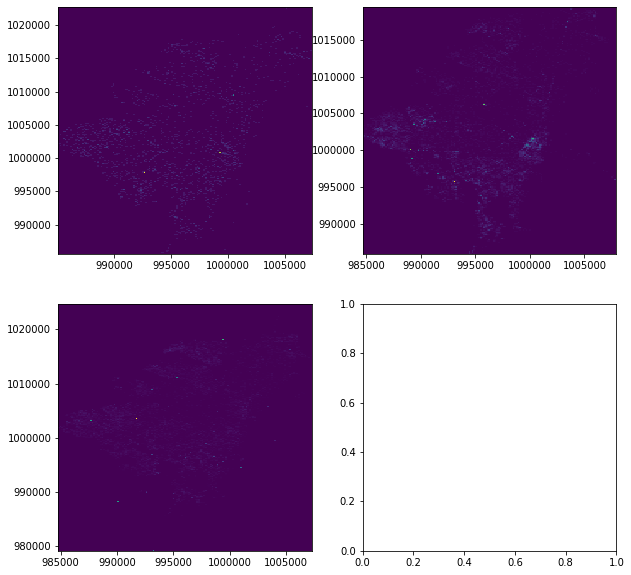

In [45]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].pcolor(*loaded_siedco['prediction'][0].mesh_data(), loaded_siedco['prediction'][0].intensity_matrix)
ax[0,1].pcolor(*loaded_rnmc['prediction'][0].mesh_data(), loaded_rnmc['prediction'][0].intensity_matrix)
ax[1,0].pcolor(*loaded_nuse['prediction'][0].mesh_data(), loaded_nuse['prediction'][0].intensity_matrix)

## Conclusion about the estimation of average prediction:
- Risk matrix for different DB prediction differ on size and location (bounding coords); depends on location of training points for each case.
- Compute average risk matrix prediction from different DB, will require a standardization of matrix. If this standardization is made based on matrix DB results (consider a the maximum size of combined matrix and transform each matrix according to this new one), an standardization should be required on each validation iteration and hour prediction.
- The most suitable way to find average map risk prediction seems to be related to generate a common region to build the prediction (e.g. city or localidad). In this case, the region (represented on matrix risk) wont be dependent of the distribution of training points for different DB. Besides, it seems a most reliable approach for the interpretation of coverages related to hit rates.